In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from slurm.rate import Rate

from squaternion import Quaternion

import pandas as pd

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

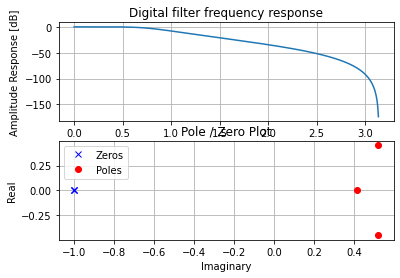

In [2]:
# https://scipy.github.io/devdocs/tutorial/signal.html
from scipy.signal import butter,filtfilt
import scipy.signal as signal

order = 3
cutoff = 50/200 # ratio of systemHz/sampleHz
flt_b, flt_a = butter(order, cutoff, btype='low', analog=False)
w, h = signal.freqz(flt_b, flt_a)
z, p, k = signal.tf2zpk(flt_b, flt_a)

plt.subplot(211)
plt.title('Digital filter frequency response')
plt.plot(w, 20*np.log10(np.abs(h)))
plt.ylabel('Amplitude Response [dB]')
plt.xlabel('Frequency (rad/sample)')
plt.grid();

plt.subplot(212)
plt.plot(np.real(z), np.imag(z), 'xb')
plt.plot(np.real(p), np.imag(p), 'or')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.ylabel('Real')
plt.xlabel('Imaginary')
plt.grid();

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
def loadPickle(filename):
    with open(filename, 'rb') as fd:
        d = pickle.load(fd)
    return d

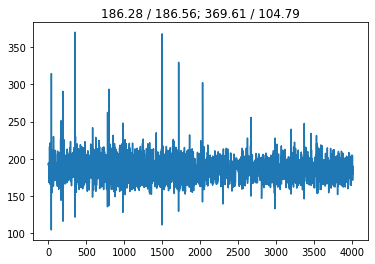

In [37]:
fname = "../../software/python/data.pickle"
data = loadPickle(fname)

accel = []
gyro = []
mag = []
pres = []
temp = []
stamp = []
for d in data:
    a,g,m,p,t,dt = d
    accel.append(a)
    gyro.append(g)
    mag.append(m)
    pres.append(p)
    temp.append(t)
    stamp.append(dt)

accel = np.array(accel)
gyro = np.array(gyro)
    
last = stamp[0]
hz = []
for t in stamp[1:]:
    hz.append(1.0/(t-last))
    last = t

plt.plot(hz)
plt.title(f"{np.mean(hz):0.2f} / {np.median(hz):0.2f}; {max(hz):0.2f} / {min(hz):0.2f}");

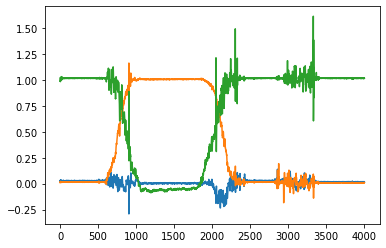

In [38]:
plt.plot(accel);

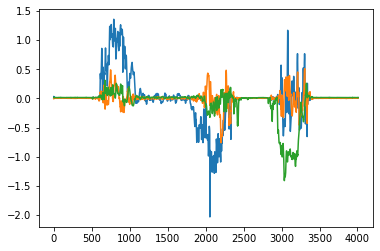

In [39]:
plt.plot(gyro);

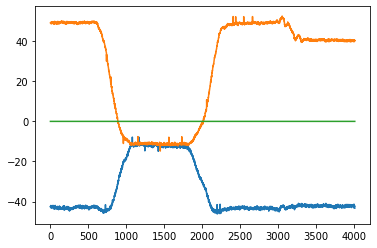

In [40]:
plt.plot(mag);

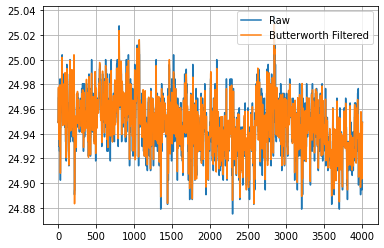

In [41]:
plt.plot(temp, label="Raw")
plt.plot(filtfilt(flt_b, flt_a, temp), label="Butterworth Filtered")
plt.legend()
plt.grid(True);

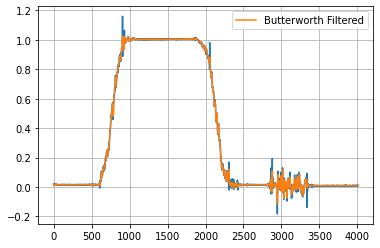

In [42]:
x = np.array(accel)[:,1]
plt.plot(x);
plt.plot(filtfilt(flt_b, flt_a, x), label="Butterworth Filtered");
plt.legend()
plt.grid(True);

In [43]:
class IMUFilter:
    """
    ref: Madgwick, An efficient orientation filter for inertial 
        and inertial/magnetic sensor arrays
    """
    def __init__(self, B, q=None):
        """
        q: [optional] initial quaternion, otherwise [1,0,0,0]
        B: Beta term in Madgwick's paper based on filter gradient learning 
        """
        self.wb = np.array([0,0,0])
        self.wcomp = True # estimate gyro bias
        self.wdr = 0.2 # gyro drift rate deg/sec/sec
        
        if q is None:
            self.q = Quaternion()
        else:
            self.q = q
            
        self.B = B

    def comp(self, del_f, dt):
        """
        Does the gyro compensation
        """
        q = self.q
        zeta = sqrt(3/4)*self.wdr*pi/180 # gyro drift: rad/s/s
        qwe = 2.0*q.conjugate*del_f # 47
        qwe = qwe.normalize
        self.wb = self.wb + zeta*np.array(qwe[1:])*dt # 48
        return self.wb

    def grad(self, a):
        """
        Calculates eqn #34, del_f/norm(del_f), which is the top
        block in the IMU flow diagram.
        """
        ax,ay,az = a
        q1,q2,q3,q4 = self.q

        fg = np.array([
            [2*(q2*q4-q1*q3)-ax],
            [2*(q1*q2+q3*q4)-ay],
            [2*(0.5-q2**2-q3**2)-az]
        ]) # 25
        Jg = np.array([
            [-2*q3,  2*q4, -2*q1, 2*q2],
            [ 2*q2,  2*q1,  2*q4, 2*q3],
            [    0, -4*q2, -4*q3,    0]
        ]) # 26, gradient of fg

        d = (Jg.T @ fg).T #[0]
        d = d.ravel()
        qq = Quaternion(*d).normalize 
        return qq.normalize

    def update(self, a, w, dt):
        """
        a: acceleration, term is normalize, so can be in any units
        w: gyro rates [rads/sec]
        dt: time step [sec]
        """
        a = a/norm(a)
        q = self.q
        del_f = self.grad(a) # gradient decent algorithm

        if self.wcomp:
            wb = self.comp(del_f,dt) # calculate bias
            w = w - wb               # 49
            
        qdw = 0.5*q*Quaternion(0,*w)
        qdot = qdw - self.B*del_f # filter
        q = q + qdot*dt           # integrate
        self.q = q.normalize
        return self.q

In [44]:
# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

start = stamp[0]
last = stamp[0]-0.1 # starting time stamp
tt = 0               # Test time
# q = Quaternion()
B = sqrt(3/4)*1*pi/180  # gyro measurement error rad/s
filt = IMUFilter(B)
filt.wcomp = True
wes = []

for a, g, ts in zip(accel, gyro, stamp):
    dt = ts - last # calculate time step
    
    q = filt.update(a,g,dt)  # get orientation
    wes.append(filt.wb) # save gyro bias est for plotting
    r,p,y = q.to_euler(degrees=True)  # convert to euler
#     r,p,y = euler(q) # madgwick's appears wrong!
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    e["tt"].append(ts-start) # keep track of test time
    last = ts  # save previous time stamp

euler2 = pd.DataFrame(e)

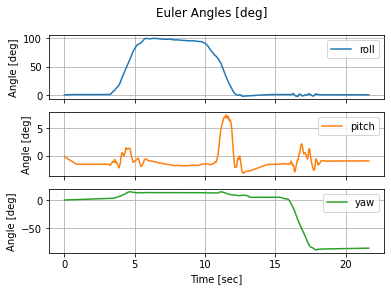

In [45]:
euler2.plot(
    x="tt", 
    subplots=True, grid=True, 
    title="Euler Angles [deg]",
    ylabel="Angle [deg]",
    xlabel="Time [sec]"
);

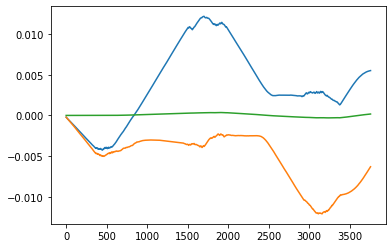

In [32]:
plt.plot(wes);